<a href="https://colab.research.google.com/github/sashanikina/NS_lab1/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm
from torchsummary import summary
import torchvision.models as models
import time

os.environ["PYTORCH_USE_CUDA_DSA"] = "1"

%matplotlib inline

In [ ]:
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda', index=0)

In [ ]:
#функция для вывода изображений
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#имена классов
classes = ("cat", "dog", "horse", "lion")

#путь до датасета
PATH = "./animals"

In [ ]:
# зададим какие преобразования необходимо сделать с каждым изображением
batch_size=40 #кол-во изображений загружаемых за раз

transform = transforms.Compose(
    [transforms.Resize((64,64)),  #изменим размер изображений
     transforms.ToTensor(),   #переведем в формат который необходим нейронной сети - тензор
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) # проведем нормализацию изображения

trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=2, shuffle=True)

testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "val"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=2, shuffle=True)

Real Labels:   lion   cat   dog  lion


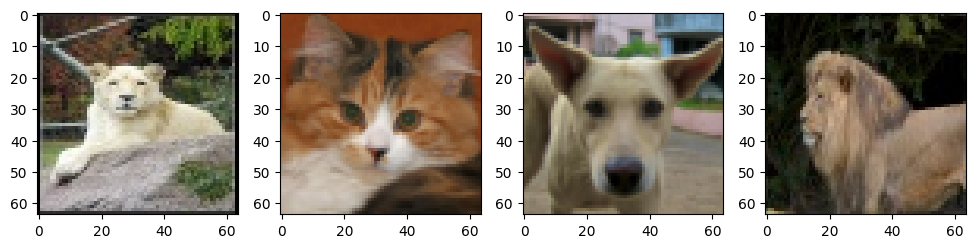

In [ ]:
#Проверим как работает наш загрузчик и посмотрим на парочку изображений
images, labels = next(iter(trainloader))
image_shower(images, labels)

In [ ]:
print(images.shape)

torch.Size([40, 3, 64, 64])


N VGG16

In [ ]:
# Инициализация модели
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        #print ('layer1-output', out.size())
        out = self.layer2(out)
        #print ('layer2-output', out.size())
        out = self.layer3(out)
        #print ('layer3-output', out.size())
        out = self.layer4(out)
        #print ('layer4-output', out.size())
        out = self.layer5(out)
        #print ('layer5-output', out.size())
        out = self.layer6(out)
        #print ('layer6-output', out.size())
        out = self.layer7(out)
        #print ('layer7-output', out.size())
        out = self.layer8(out)
        #print ('layer8-output', out.size())
        out = self.layer9(out)
        #print ('layer9-output', out.size())
        out = self.layer10(out)
        #print ('layer10-output', out.size())
        out = self.layer11(out)
        #print ('layer11-output', out.size())
        out = self.layer12(out)
        #print ('layer12-output', out.size())
        out = self.layer13(out)
        #print ('layer13-output', out.size())
        out = out.reshape(out.size(0), -1)
        #print ('reshape-output', out.size())
        out = self.fc(out)
        #print ('fc-output', out.size())
        out = self.fc1(out)
        #print ('fc1-output', out.size())
        out = self.fc2(out)
        #print ('fc2-output', out.size())
        return out

In [ ]:
vgg16 = VGG16(len(classes)).to(device)
batch_size=40 #кол-во изображений загружаемый за раз
summary(vgg16,(3,64,64),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [40, 64, 64, 64]           1,792
       BatchNorm2d-2           [40, 64, 64, 64]             128
              ReLU-3           [40, 64, 64, 64]               0
            Conv2d-4           [40, 64, 64, 64]          36,928
       BatchNorm2d-5           [40, 64, 64, 64]             128
              ReLU-6           [40, 64, 64, 64]               0
         MaxPool2d-7           [40, 64, 32, 32]               0
            Conv2d-8          [40, 128, 32, 32]          73,856
       BatchNorm2d-9          [40, 128, 32, 32]             256
             ReLU-10          [40, 128, 32, 32]               0
           Conv2d-11          [40, 128, 32, 32]         147,584
      BatchNorm2d-12          [40, 128, 32, 32]             256
             ReLU-13          [40, 128, 32, 32]               0
        MaxPool2d-14          [40, 128,

In [ ]:
criterion = torch.nn.CrossEntropyLoss() #функция ошибок по сравнению с исходными классами

learning_rate = 0.0001

optimizer = torch.optim.Adam(vgg16.parameters(),learning_rate)

epoches = 10

batch_size=40 #кол-во изображений загружаемый за раз

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных

    running_loss = 0.0
    loss_val = 0.0

    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].

        inputs, labels = data[0].to(device), data[1].to(device)
        # кидаем данные на девойс, т.к. сеть тоже на девайсе

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward() #???
        optimizer.step() #???

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 10 == 9:    # вывести каждые 300 images
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,   400] loss: 0.278
[1,   800] loss: 0.248
[1,  1200] loss: 0.225
[1,  1600] loss: 0.210
[1,  2000] loss: 0.190
[1,  2400] loss: 0.182
[1,  2800] loss: 0.146
[1,  3200] loss: 0.137
[1,  3600] loss: 0.118
[1,  4000] loss: 0.109
[1,  4400] loss: 0.111
[1,  4800] loss: 0.104
[1,  5200] loss: 0.100
[1,  5600] loss: 0.092
[1,  6000] loss: 0.098
[1,  6400] loss: 0.094
[1,  6800] loss: 0.068
[1,  7200] loss: 0.067
[1,  7600] loss: 0.072
[1,  8000] loss: 0.077
[1,  8400] loss: 0.069
[1,  8800] loss: 0.083
[1,  9200] loss: 0.076
[1,  9600] loss: 0.079
[1, 10000] loss: 0.065
[1, 10400] loss: 0.056
[2,   400] loss: 0.052
[2,   800] loss: 0.045
[2,  1200] loss: 0.049
[2,  1600] loss: 0.056
[2,  2000] loss: 0.050
[2,  2400] loss: 0.055
[2,  2800] loss: 0.051
[2,  3200] loss: 0.053
[2,  3600] loss: 0.059
[2,  4000] loss: 0.050
[2,  4400] loss: 0.055
[2,  4800] loss: 0.054
[2,  5200] loss: 0.046
[2,  5600] loss: 0.055
[2,  6000] loss: 0.052
[2,  6400] loss: 0.042
[2,  6800] loss: 0.052
[2,  7200] 

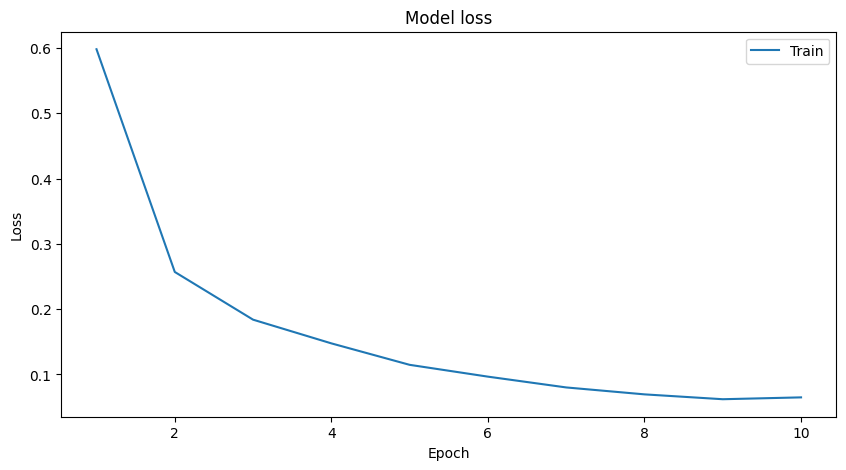

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:

        img, labels = data[0].to(device), data[1].to(device)

        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = vgg16(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 92 %


In [ ]:
# Подготовка
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        outputs = vgg16(img)
        _, predictions = torch.max(outputs, 1)
        # собираем правильные прогнозы для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Выводим точность на каждом классе
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cat   is 97.3 %
Accuracy for class: dog   is 94.7 %
Accuracy for class: horse is 89.3 %
Accuracy for class: lion  is 89.9 %


N VGG19

In [ ]:
# Инициализация модели
class VGG19(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer9 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer14 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer15 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer16 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        #print ('layer1-output', out.size())
        out = self.layer2(out)
        #print ('layer2-output', out.size())
        out = self.layer3(out)
        #print ('layer3-output', out.size())
        out = self.layer4(out)
        #print ('layer4-output', out.size())
        out = self.layer5(out)
        #print ('layer5-output', out.size())
        out = self.layer6(out)
        #print ('layer6-output', out.size())
        out = self.layer7(out)
        #print ('layer7-output', out.size())
        out = self.layer8(out)
        #print ('layer8-output', out.size())
        out = self.layer9(out)
        #print ('layer9-output', out.size())
        out = self.layer10(out)
        #print ('layer10-output', out.size())
        out = self.layer11(out)
        #print ('layer11-output', out.size())
        out = self.layer12(out)
        #print ('layer12-output', out.size())
        out = self.layer13(out)
        #print ('layer13-output', out.size())
        out = self.layer14(out)
        #print ('layer13-output', out.size())
        out = self.layer15(out)
        #print ('layer13-output', out.size())
        out = self.layer16(out)
        #print ('layer13-output', out.size())
        out = out.reshape(out.size(0), -1)
        #print ('reshape-output', out.size())
        out = self.fc(out)
        #print ('fc-output', out.size())
        out = self.fc1(out)
        #print ('fc1-output', out.size())
        out = self.fc2(out)
        #print ('fc2-output', out.size())
        return out

In [ ]:
vgg19 = VGG19(len(classes)).to(device)
batch_size=40 #кол-во изображений загружаемый за раз
summary(vgg19,(3,64,64),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [40, 64, 64, 64]           1,792
       BatchNorm2d-2           [40, 64, 64, 64]             128
              ReLU-3           [40, 64, 64, 64]               0
            Conv2d-4           [40, 64, 64, 64]          36,928
       BatchNorm2d-5           [40, 64, 64, 64]             128
              ReLU-6           [40, 64, 64, 64]               0
         MaxPool2d-7           [40, 64, 32, 32]               0
            Conv2d-8          [40, 128, 32, 32]          73,856
       BatchNorm2d-9          [40, 128, 32, 32]             256
             ReLU-10          [40, 128, 32, 32]               0
           Conv2d-11          [40, 128, 32, 32]         147,584
      BatchNorm2d-12          [40, 128, 32, 32]             256
             ReLU-13          [40, 128, 32, 32]               0
        MaxPool2d-14          [40, 128,

In [ ]:
criterion = torch.nn.CrossEntropyLoss() #функция ошибок по сравнению с исходными классами

learning_rate = 0.0001

optimizer = torch.optim.Adam(vgg19.parameters(),learning_rate)

epoches = 10

batch_size=40 #кол-во изображений загружаемых за раз

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных

    running_loss = 0.0
    loss_val = 0.0


    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)
        #кидаем данные на девойс, т.к. сеть тоже на девайсе

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg19(inputs)
        loss = criterion(outputs, labels)
        loss.backward() #???
        optimizer.step() #???

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 40 == 39:
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  1600] loss: 1.022
[1,  3200] loss: 0.774
[1,  4800] loss: 0.618
[1,  6400] loss: 0.463
[1,  8000] loss: 0.409
[1,  9600] loss: 0.337
[2,  1600] loss: 0.313
[2,  3200] loss: 0.260
[2,  4800] loss: 0.277
[2,  6400] loss: 0.239
[2,  8000] loss: 0.266
[2,  9600] loss: 0.209
[3,  1600] loss: 0.186
[3,  3200] loss: 0.201
[3,  4800] loss: 0.163
[3,  6400] loss: 0.196
[3,  8000] loss: 0.169
[3,  9600] loss: 0.166
[4,  1600] loss: 0.139
[4,  3200] loss: 0.139
[4,  4800] loss: 0.123
[4,  6400] loss: 0.150
[4,  8000] loss: 0.131
[4,  9600] loss: 0.131
[5,  1600] loss: 0.128
[5,  3200] loss: 0.122
[5,  4800] loss: 0.122
[5,  6400] loss: 0.098
[5,  8000] loss: 0.115
[5,  9600] loss: 0.147
[6,  1600] loss: 0.073
[6,  3200] loss: 0.080
[6,  4800] loss: 0.067
[6,  6400] loss: 0.089
[6,  8000] loss: 0.104
[6,  9600] loss: 0.161
[7,  1600] loss: 0.118
[7,  3200] loss: 0.093
[7,  4800] loss: 0.071
[7,  6400] loss: 0.081
[7,  8000] loss: 0.117
[7,  9600] loss: 0.075
[8,  1600] loss: 0.079
[8,  3200] 

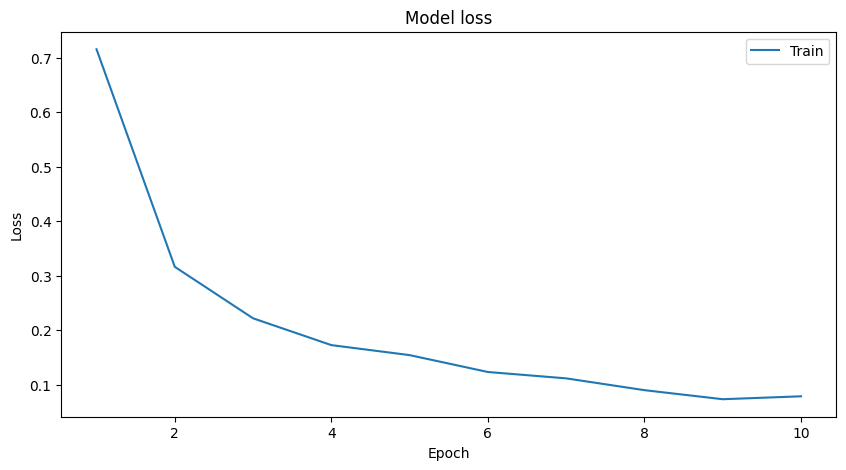

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = vgg19(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 93 %


In [ ]:
# Подготовка
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        outputs = vgg19(img)
        _, predictions = torch.max(outputs, 1)
        # собираем правильные прогнозы для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Выводим точность на каждом классе
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cat   is 95.7 %
Accuracy for class: dog   is 98.3 %
Accuracy for class: horse is 93.0 %
Accuracy for class: lion  is 86.9 %


N AlexNet

In [ ]:
# Инициализация модели
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=5),
            nn.BatchNorm2d(96),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Linear(1024, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        #print ('layer1-output', out.size())
        out = self.layer2(out)
        #print ('layer2-output', out.size())
        out = self.layer3(out)
        #print ('layer3-output', out.size())
        out = self.layer4(out)
        #print ('layer4-output', out.size())
        out = self.layer5(out)
        #print ('layer5-output', out.size())
        out = out.reshape(out.size(0), -1)
        #print ('reshape-output', out.size())
        out = self.fc(out)
        #print ('fc-output', out.size())
        out = self.fc1(out)
        #print ('fc1-output', out.size())
        out = self.fc2(out)
        #print ('fc2-output', out.size())
        return out

In [ ]:
batch_size=40 #кол-во изображений загружаемых за раз

alexnet = AlexNet(len(classes)).to(device)
summary(alexnet,(3,64,64),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [40, 96, 16, 16]          34,944
       BatchNorm2d-2           [40, 96, 16, 16]             192
              ReLU-3           [40, 96, 16, 16]               0
            Conv2d-4          [40, 256, 16, 16]         614,656
       BatchNorm2d-5          [40, 256, 16, 16]             512
              ReLU-6          [40, 256, 16, 16]               0
         MaxPool2d-7            [40, 256, 8, 8]               0
            Conv2d-8            [40, 384, 8, 8]         885,120
       BatchNorm2d-9            [40, 384, 8, 8]             768
             ReLU-10            [40, 384, 8, 8]               0
        MaxPool2d-11            [40, 384, 4, 4]               0
           Conv2d-12            [40, 384, 4, 4]       1,327,488
      BatchNorm2d-13            [40, 384, 4, 4]             768
             ReLU-14            [40, 38

In [ ]:
criterion = torch.nn.CrossEntropyLoss() #функция ошибок по сравнению с исходными классами

learning_rate = 0.001

optimizer = torch.optim.Adam(alexnet.parameters(),learning_rate)

epoches = 10

batch_size=40 #кол-во изображений загружаемых за раз

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных

    running_loss = 0.0
    loss_val = 0.0


    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)
        #кидаем данные на девойс, т.к. сеть тоже на девайсе

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward() #???
        optimizer.step() #???

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 40 == 39:
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  1600] loss: 1.473
[1,  3200] loss: 1.066
[1,  4800] loss: 1.017
[1,  6400] loss: 0.998
[1,  8000] loss: 0.955
[1,  9600] loss: 0.928
[2,  1600] loss: 0.846
[2,  3200] loss: 0.799
[2,  4800] loss: 0.733
[2,  6400] loss: 0.691
[2,  8000] loss: 0.655
[2,  9600] loss: 0.626
[3,  1600] loss: 0.529
[3,  3200] loss: 0.496
[3,  4800] loss: 0.447
[3,  6400] loss: 0.460
[3,  8000] loss: 0.443
[3,  9600] loss: 0.423
[4,  1600] loss: 0.308
[4,  3200] loss: 0.341
[4,  4800] loss: 0.356
[4,  6400] loss: 0.352
[4,  8000] loss: 0.313
[4,  9600] loss: 0.319
[5,  1600] loss: 0.240
[5,  3200] loss: 0.272
[5,  4800] loss: 0.237
[5,  6400] loss: 0.264
[5,  8000] loss: 0.247
[5,  9600] loss: 0.257
[6,  1600] loss: 0.179
[6,  3200] loss: 0.214
[6,  4800] loss: 0.209
[6,  6400] loss: 0.218
[6,  8000] loss: 0.223
[6,  9600] loss: 0.220
[7,  1600] loss: 0.202
[7,  3200] loss: 0.175
[7,  4800] loss: 0.159
[7,  6400] loss: 0.184
[7,  8000] loss: 0.182
[7,  9600] loss: 0.193
[8,  1600] loss: 0.116
[8,  3200] 

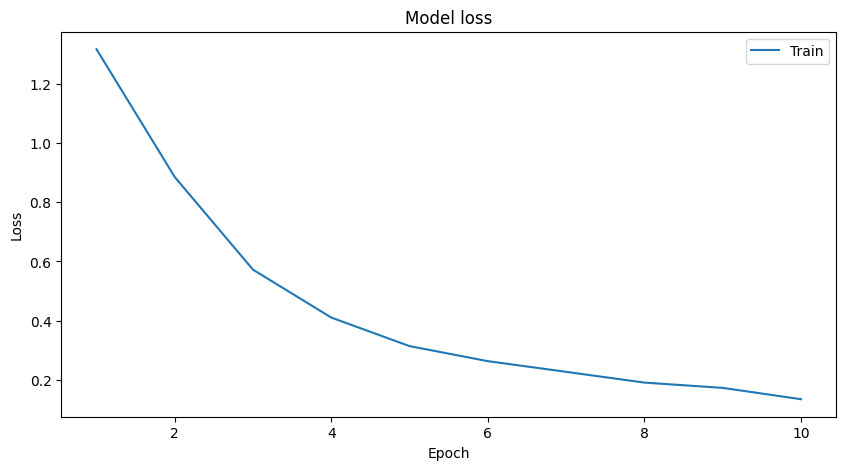

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = alexnet(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 89 %


In [ ]:
# Подготовка
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(img)
        _, predictions = torch.max(outputs, 1)
        # собираем правильные прогнозы для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Выводим точность на каждом классе
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cat   is 96.0 %
Accuracy for class: dog   is 86.7 %
Accuracy for class: horse is 87.7 %
Accuracy for class: lion  is 85.9 %


In [ ]:
Оптимизаторы SGD

SyntaxError: invalid syntax (1955534089.py, line 1)

In [ ]:
net21 = AlexNet(len(classes)).to(device)

criterion = torch.nn.CrossEntropyLoss() #функция ошибок по сравнению с исходными классами

learning_rate = 0.01

optimizer = torch.optim.SGD(net21.parameters(),learning_rate)

epoches = 10

batch_size=40 #кол-во изображений загружаемых за раз

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных

    running_loss = 0.0
    loss_val = 0.0


    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)
        #кидаем данные на девойс, т.к. сеть тоже на девайсе

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net21(inputs)
        loss = criterion(outputs, labels)
        loss.backward() #???
        optimizer.step() #???

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 40 == 39:    # вывести каждые 1000 images
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  1600] loss: 1.035
[1,  3200] loss: 0.906
[1,  4800] loss: 0.756
[1,  6400] loss: 0.627
[1,  8000] loss: 0.564
[1,  9600] loss: 0.519
[2,  1600] loss: 0.391
[2,  3200] loss: 0.345
[2,  4800] loss: 0.361
[2,  6400] loss: 0.312
[2,  8000] loss: 0.344
[2,  9600] loss: 0.313
[3,  1600] loss: 0.212
[3,  3200] loss: 0.204
[3,  4800] loss: 0.228
[3,  6400] loss: 0.204
[3,  8000] loss: 0.207
[3,  9600] loss: 0.201
[4,  1600] loss: 0.142
[4,  3200] loss: 0.133
[4,  4800] loss: 0.119
[4,  6400] loss: 0.127
[4,  8000] loss: 0.134
[4,  9600] loss: 0.140
[5,  1600] loss: 0.078
[5,  3200] loss: 0.059
[5,  4800] loss: 0.089
[5,  6400] loss: 0.093
[5,  8000] loss: 0.076
[5,  9600] loss: 0.097
[6,  1600] loss: 0.046
[6,  3200] loss: 0.039
[6,  4800] loss: 0.041
[6,  6400] loss: 0.051
[6,  8000] loss: 0.043
[6,  9600] loss: 0.067
[7,  1600] loss: 0.027
[7,  3200] loss: 0.020
[7,  4800] loss: 0.019
[7,  6400] loss: 0.037
[7,  8000] loss: 0.043
[7,  9600] loss: 0.033
[8,  1600] loss: 0.024
[8,  3200] 

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net21(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 91 %


In [ ]:
# Подготовка
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        outputs = net21(img)
        _, predictions = torch.max(outputs, 1)
        # собираем правильные прогнозы для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Выводим точность на каждом классе
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cat   is 93.7 %
Accuracy for class: dog   is 93.3 %
Accuracy for class: horse is 90.7 %
Accuracy for class: lion  is 86.6 %


In [ ]:
RMSprop

NameError: name 'RMSprop' is not defined

In [ ]:
net22 = AlexNet(len(classes)).to(device)

criterion = torch.nn.CrossEntropyLoss() #функция ошибок по сравнению с исходными классами

learning_rate = 0.001

optimizer = torch.optim.RMSprop(net22.parameters(),learning_rate)

epoches = 10

batch_size=40 #кол-во изображений загружаемых за раз

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных

    running_loss = 0.0
    loss_val = 0.0


    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)
        #кидаем данные на девойс, т.к. сеть тоже на девайсе

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net22(inputs)
        loss = criterion(outputs, labels)
        loss.backward() #???
        optimizer.step() #???

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 40 == 39:    # вывести каждые 1000 images
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  1600] loss: 26.623
[1,  3200] loss: 1.089
[1,  4800] loss: 1.061
[1,  6400] loss: 1.063
[1,  8000] loss: 1.051
[1,  9600] loss: 1.062
[2,  1600] loss: 1.050
[2,  3200] loss: 1.032
[2,  4800] loss: 1.041
[2,  6400] loss: 1.039
[2,  8000] loss: 1.026
[2,  9600] loss: 1.016
[3,  1600] loss: 0.976
[3,  3200] loss: 0.962
[3,  4800] loss: 0.932
[3,  6400] loss: 0.922
[3,  8000] loss: 0.871
[3,  9600] loss: 0.844
[4,  1600] loss: 0.781
[4,  3200] loss: 0.715
[4,  4800] loss: 0.705
[4,  6400] loss: 0.655
[4,  8000] loss: 0.591
[4,  9600] loss: 0.550
[5,  1600] loss: 0.502
[5,  3200] loss: 0.453
[5,  4800] loss: 0.425
[5,  6400] loss: 0.402
[5,  8000] loss: 0.433
[5,  9600] loss: 0.378
[6,  1600] loss: 0.343
[6,  3200] loss: 0.333
[6,  4800] loss: 0.334
[6,  6400] loss: 0.325
[6,  8000] loss: 0.316
[6,  9600] loss: 0.296
[7,  1600] loss: 0.254
[7,  3200] loss: 0.281
[7,  4800] loss: 0.295
[7,  6400] loss: 0.238
[7,  8000] loss: 0.264
[7,  9600] loss: 0.240
[8,  1600] loss: 0.221
[8,  3200]

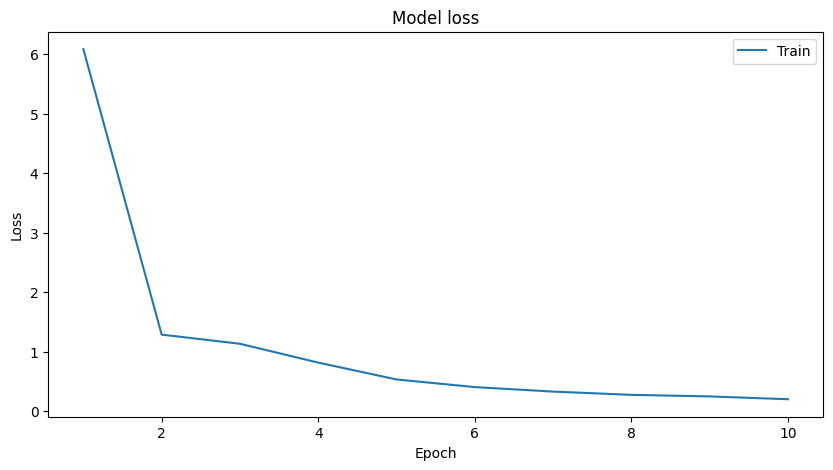

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net22(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 89 %


In [ ]:
# Подготовка
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        outputs = net22(img)
        _, predictions = torch.max(outputs, 1)
        # собираем правильные прогнозы для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Выводим точность на каждом классе
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cat   is 92.3 %
Accuracy for class: dog   is 86.7 %
Accuracy for class: horse is 88.3 %
Accuracy for class: lion  is 85.6 %


In [ ]:
Adagrad

NameError: name 'Adagrad' is not defined

In [ ]:
net23 = AlexNet(len(classes)).to(device)

criterion = torch.nn.CrossEntropyLoss() #функция ошибок по сравнению с исходными классами

learning_rate = 0.001

optimizer = torch.optim.Adagrad(net23.parameters(),learning_rate)

epoches = 10

batch_size=40 #кол-во изображений загружаемых за раз

In [ ]:
loss_list=[]
for epoch in range(epoches):  # многократное прохождение по набору данных

    running_loss = 0.0
    loss_val = 0.0


    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)
        #кидаем данные на девойс, т.к. сеть тоже на девайсе

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net23(inputs)
        loss = criterion(outputs, labels)
        loss.backward() #???
        optimizer.step() #???

        # вывести статистику обучения
        running_loss += loss.item()
        loss_val += loss.item()
        if i % 40 == 39:    # вывести каждые 1000 images
            print(f'[{epoch + 1}, {(i + 1)*batch_size:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    loss_list.append(loss_val/len(trainloader))

print('Finished Training')

[1,  1600] loss: 1.403
[1,  3200] loss: 0.905
[1,  4800] loss: 0.771
[1,  6400] loss: 0.609
[1,  8000] loss: 0.506
[1,  9600] loss: 0.416
[2,  1600] loss: 0.303
[2,  3200] loss: 0.282
[2,  4800] loss: 0.295
[2,  6400] loss: 0.281
[2,  8000] loss: 0.259
[2,  9600] loss: 0.258
[3,  1600] loss: 0.173
[3,  3200] loss: 0.164
[3,  4800] loss: 0.142
[3,  6400] loss: 0.165
[3,  8000] loss: 0.151
[3,  9600] loss: 0.151
[4,  1600] loss: 0.098
[4,  3200] loss: 0.102
[4,  4800] loss: 0.098
[4,  6400] loss: 0.089
[4,  8000] loss: 0.093
[4,  9600] loss: 0.086
[5,  1600] loss: 0.048
[5,  3200] loss: 0.045
[5,  4800] loss: 0.059
[5,  6400] loss: 0.078
[5,  8000] loss: 0.048
[5,  9600] loss: 0.044
[6,  1600] loss: 0.020
[6,  3200] loss: 0.019
[6,  4800] loss: 0.028
[6,  6400] loss: 0.023
[6,  8000] loss: 0.030
[6,  9600] loss: 0.038
[7,  1600] loss: 0.013
[7,  3200] loss: 0.011
[7,  4800] loss: 0.009
[7,  6400] loss: 0.015
[7,  8000] loss: 0.023
[7,  9600] loss: 0.017
[8,  1600] loss: 0.011
[8,  3200] 

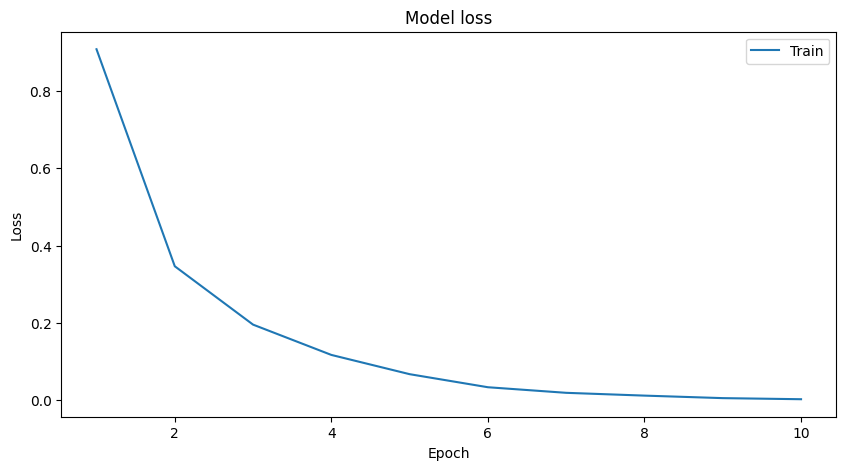

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, epoches+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net23(img)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 90 %


In [ ]:
# Подготовка
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        img, labels = data[0].to(device), data[1].to(device)
        outputs = net23(img)
        _, predictions = torch.max(outputs, 1)
        # собираем правильные прогнозы для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Выводим точность на каждом классе
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cat   is 95.7 %
Accuracy for class: dog   is 91.3 %
Accuracy for class: horse is 88.0 %
Accuracy for class: lion  is 86.2 %


In [ ]:
import ipywidgets as widgets
from fastbook import *
from fastai.vision.all import *

In [ ]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

Predicted class:  cat
{'cat': 3.76, 'dog': 3.47, 'horse': -4.61, 'lion': -2.33}


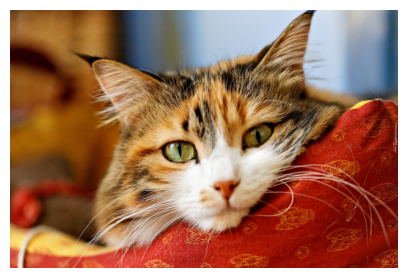

In [ ]:
img = PILImage.create(uploader.data[0])
img.show()
img_tensor = transform(img).to(device)
img_tensor = img_tensor.unsqueeze(0)

predictions = {classname: 0 for classname in classes}

with torch.no_grad():
  outputs = net21(img_tensor)
  pred_out, pred_index = torch.max(outputs, 1)
  print("Predicted class: ", classes[pred_index])

count = 0
for a in predictions:
  predictions[a] = round(float(outputs[0][count].item()), 2)
  count += 1
print(predictions)

In [ ]:
FROM TRAINED NN

In [ ]:
def dfs_freeze(model):
    for param in model.parameters():
        param.requires_grad = False
    return model


def dfs_unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True
    return model

In [ ]:
from torchvision.models import ResNet50_Weights

model_ft = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

model_ft = dfs_freeze(model_ft)
model_ft.layer4[-1] = dfs_unfreeze(model_ft.layer4[-1])
model_ft.layer4[-2] = dfs_unfreeze(model_ft.layer4[-2])
model_ft.layer4[-3] = dfs_unfreeze(model_ft.layer4[-3])
model_ft.avgpool = dfs_unfreeze(model_ft.avgpool)
model_ft.fc = nn.Sequential(nn.ReLU(inplace=True),
                        nn.Linear(model_ft.fc.in_features, 512),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),
                        nn.Linear(512, 196))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)

In [ ]:
def accuracy(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        correct = 0
        correct += torch.sum(pred == target).item()
    return correct / len(target)

In [ ]:
def train_model(model, criterion, optimizer, n_epochs = 10):

    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        print("Epoch - %s, duration - %d s, loss - %.4f" % (epoch+1, epoch_duration, epoch_loss))

        losses.append(epoch_loss)

        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)

        model.train()
        since = time.time()
    print('Finished Training')
    return model, losses, test_accuracies

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print(f'{correct}/{total} - %d %%' % (
        test_acc))
    return test_acc

In [ ]:
model_ft, training_losses, test_accs = train_model(model_ft, criterion, optimizer, n_epochs=10)

Epoch - 1, duration - 30 s, loss - 0.2579
1147.0/1198.0 - 95 %
Epoch - 2, duration - 25 s, loss - 0.0628
1160.0/1198.0 - 96 %
Epoch - 3, duration - 24 s, loss - 0.0394
1158.0/1198.0 - 96 %
Epoch - 4, duration - 25 s, loss - 0.0373
1159.0/1198.0 - 96 %
Epoch - 5, duration - 25 s, loss - 0.0224
1157.0/1198.0 - 96 %
Epoch - 6, duration - 25 s, loss - 0.0256
1153.0/1198.0 - 96 %
Epoch - 7, duration - 24 s, loss - 0.0213
1149.0/1198.0 - 95 %
Epoch - 8, duration - 25 s, loss - 0.0158
1161.0/1198.0 - 96 %
Epoch - 9, duration - 26 s, loss - 0.0126
1154.0/1198.0 - 96 %
Epoch - 10, duration - 26 s, loss - 0.0147
1157.0/1198.0 - 96 %
Finished Training


In [ ]:
from torchsummary import summary
summary(model_ft,(3,224,224),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [40, 64, 112, 112]           9,408
       BatchNorm2d-2         [40, 64, 112, 112]             128
              ReLU-3         [40, 64, 112, 112]               0
         MaxPool2d-4           [40, 64, 56, 56]               0
            Conv2d-5           [40, 64, 56, 56]           4,096
       BatchNorm2d-6           [40, 64, 56, 56]             128
              ReLU-7           [40, 64, 56, 56]               0
            Conv2d-8           [40, 64, 56, 56]          36,864
       BatchNorm2d-9           [40, 64, 56, 56]             128
             ReLU-10           [40, 64, 56, 56]               0
           Conv2d-11          [40, 256, 56, 56]          16,384
      BatchNorm2d-12          [40, 256, 56, 56]             512
           Conv2d-13          [40, 256, 56, 56]          16,384
      BatchNorm2d-14          [40, 256,

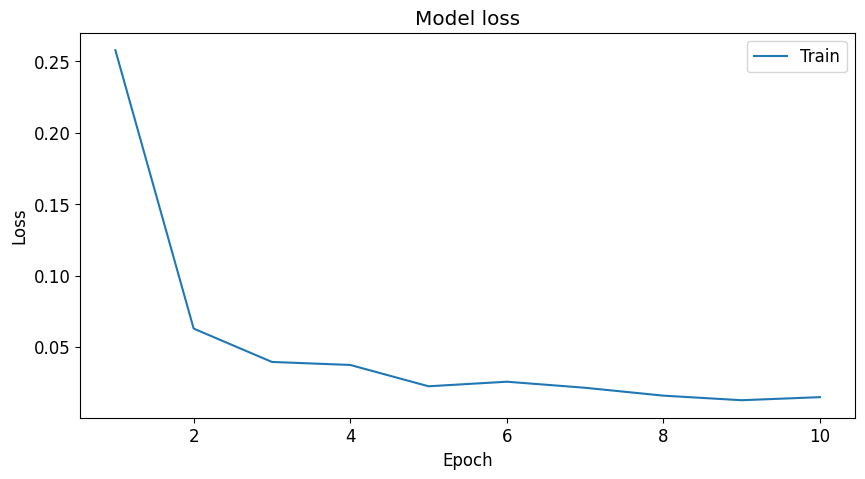

In [ ]:
import matplotlib.pyplot as plt
n_epochs = 10
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, n_epochs+1)),training_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

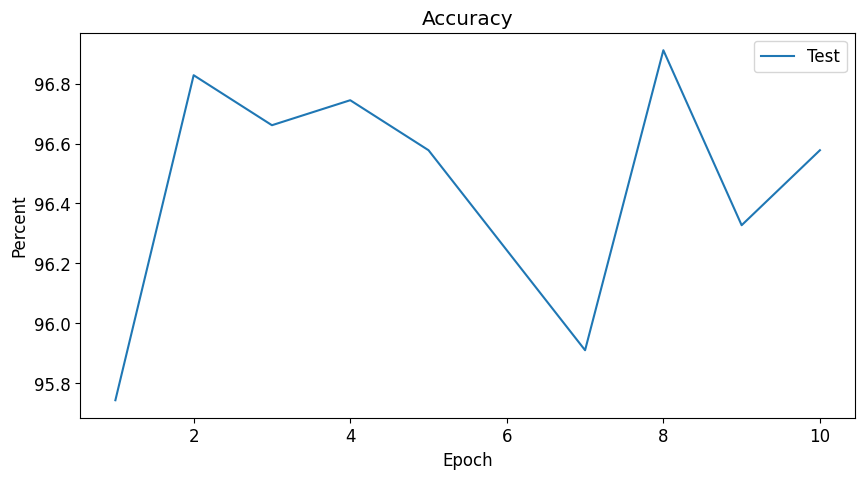

In [ ]:
import matplotlib.pyplot as plt
n_epochs = 10
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, n_epochs+1)),test_accs)
plt.title('Accuracy')
plt.ylabel('Percent')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper right')
plt.show()